In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import relu

2023-03-21 11:40:24.178212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 11:40:24.401766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-21 11:40:25.168896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

In [2]:
!git clone https://github.com/Shankar0x/Datasets.git imgs
from PIL import Image

fatal: destination path 'imgs' already exists and is not an empty directory.


X_train shape:  (200, 192, 256, 3)
Y_train shape:  (200, 192, 256)


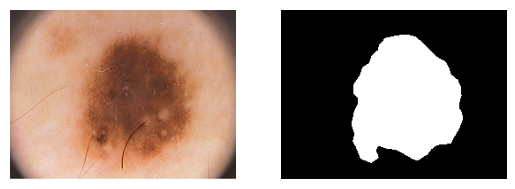

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


filelist_trainx = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Train_images/Trainx/*.bmp'), key=numericalSort)
x_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Train_masks/Trainy/*.bmp'), key=numericalSort)
y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/images/*.tif'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/masks/*.tif'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainx/*.jpg'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainy/*.jpg'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])


print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
plt.subplot(1,2,1)
plt.imshow(x_train[0].astype('uint8'))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_train[0].astype('uint8'),cmap = plt.cm.binary_r)
plt.axis('off')
plt.show()

In [4]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=101)

In [5]:
print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (150, 192, 256, 3)
Y_train shape:  (150, 192, 256)
X_test shape:  (50, 192, 256, 3)
Y_test shape:  (50, 192, 256)


In [6]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [7]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [8]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [9]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

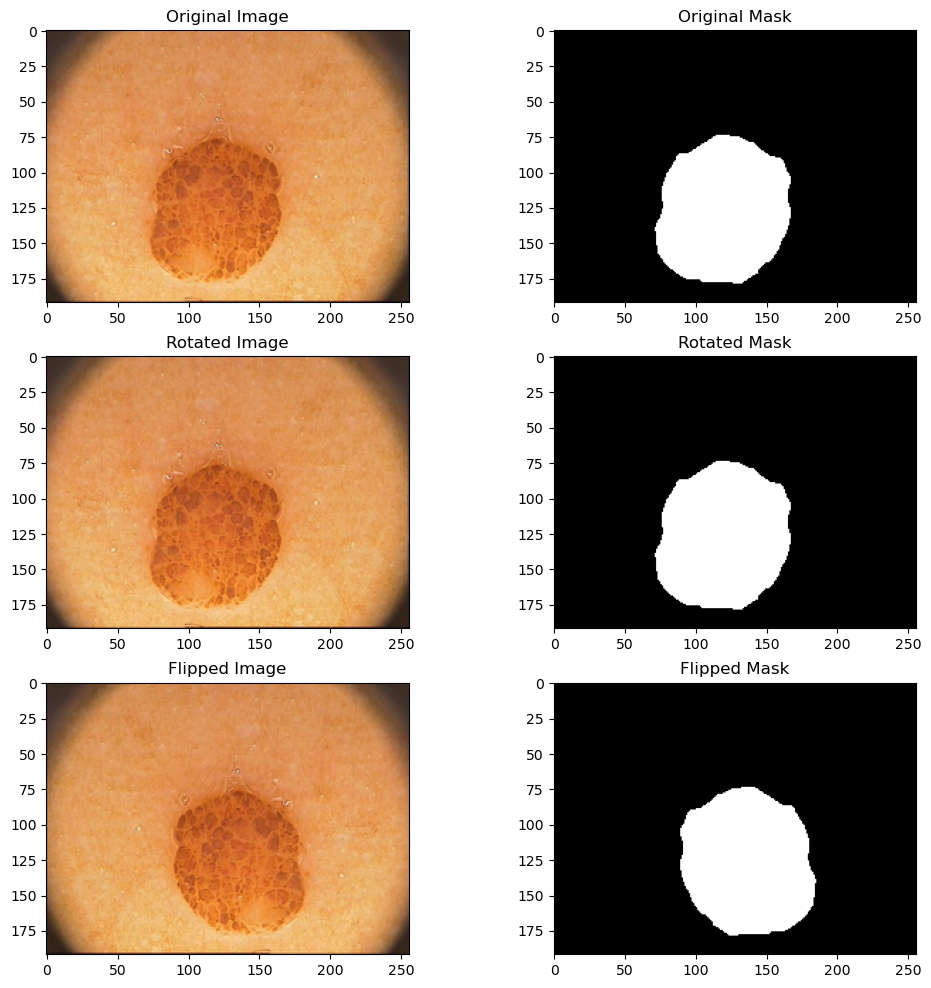

In [10]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [11]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [12]:
y_train_full.shape

(450, 192, 256)

In [13]:
# expanding dimensions of the masks
y_train_full_exp = np.zeros((y_train_full.shape[0], y_train_full.shape[1], y_train_full.shape[2],1))
for i in range(y_train_full.shape[0]):
    y_train_full_exp[i] = np.expand_dims(y_train_full[i], 2)

y_test_exp = np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))
for i in range(y_test.shape[0]):
    y_test_exp[i] = np.expand_dims(y_test[i],2)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full_exp, test_size = 0.20, random_state = 101)

In [15]:
y_test = y_test_exp
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test_exp.shape)
print(x_val.shape)
print(y_val.shape)

(360, 192, 256, 3)
(360, 192, 256, 1)
(50, 192, 256, 3)
(50, 192, 256, 1)
(90, 192, 256, 3)
(90, 192, 256, 1)


### Old code

In [16]:
# image_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_images/Trainx/'
# mask_directory = 'imgs/Resized_Skin_Lesion_Dataset/Train_masks/Trainy/'

In [17]:
# SIZE = 256
# image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
# mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

# images = os.listdir(image_directory)
# for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
#     if (image_name.split('.')[1] == 'bmp'):
#         #print(image_directory+image_name)
#         image = cv2.imread(image_directory+image_name, 1)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         image_dataset.append(np.array(image))

In [18]:
# masks = os.listdir(mask_directory)
# for i, image_name in enumerate(masks):
#     if (image_name.split('.')[1] == 'bmp'):
#         image = cv2.imread(mask_directory+image_name, 0)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         mask_dataset.append(np.array(image))

In [19]:
# #Normalize images
# image_dataset = np.array(image_dataset)/255.
# #D not normalize masks, just rescale to 0 to 1.
# mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [20]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

In [21]:
# X_train.shape

In [22]:
# y_train.shape

In [23]:
# import random
# import numpy as np
# image_number = random.randint(0, len(X_train))
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)))
# plt.subplot(122)
# plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
# plt.show()

In [24]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.models import Model

In [26]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [27]:
def RR_CONV(X, channel, kernel_size=3, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr'):
    '''
    Recurrent convolutional layers with skip connection.
    
    RR_CONV(X, channel, kernel_size=3, stack_num=2, recur_num=2, activation='ReLU', batch_norm=False, name='rr')
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of stacked recurrent convolutional layers.
        recur_num: number of recurrent iterations.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    
    activation_func = eval(activation)
    
    layer_skip = layers.Conv2D(channel, 1, name='{}_conv'.format(name))(X)
    layer_main = layer_skip
    
    for i in range(stack_num):

        layer_res = layers.Conv2D(channel, kernel_size, padding='same', name='{}_conv{}'.format(name, i))(layer_main)
        
        if batch_norm:
            layer_res = layers.BatchNormalization(name='{}_bn{}'.format(name, i))(layer_res)
            
        layer_res = activation_func(layer_res)
            
        for j in range(recur_num):
            
            layer_add = layers.add([layer_res, layer_main], name='{}_add{}_{}'.format(name, i, j))
            
            layer_res = layers.Conv2D(channel, kernel_size, padding='same', name='{}_conv{}_{}'.format(name, i, j))(layer_add)
            
            if batch_norm:
                layer_res = layers.BatchNormalization(name='{}_bn{}_{}'.format(name, i, j))(layer_res)
                
            layer_res = activation_func(layer_res)
            
        layer_main = layer_res

    out_layer = layers.add([layer_main, layer_skip], name='{}_add{}'.format(name, i))
    
    return out_layer

In [31]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


# def res_conv_block_2(x, filter_size, size, dropout, batch_norm=False):

#     conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation('relu')(conv)
    
#     conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
#     if dropout > 0:
#         conv = layers.Dropout(dropout)(conv)

#     shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
#     if batch_norm is True:
#         shortcut = layers.BatchNormalization(axis=3)(shortcut)

#     res_path = layers.add([shortcut, conv])
#     res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
#     return res_path

# def res_conv_block_3(x, filter_size, size, dropout, batch_norm=False):

#     conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation('relu')(conv)
    
#     conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation('relu')(conv)
    
#     conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
#     if dropout > 0:
#         conv = layers.Dropout(dropout)(conv)

#     shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
#     if batch_norm is True:
#         shortcut = layers.BatchNormalization(axis=3)(shortcut)

#     res_path = layers.add([shortcut, conv])
#     res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
#     return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [34]:
def Attention_ResSegNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    
    conv_64 = RR_CONV(inputs, FILTER_NUM, FILTER_SIZE, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr1')
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 2
    conv_128 = RR_CONV(pool_64, 2*FILTER_NUM, FILTER_SIZE, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr2')
    pool_128 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 3
    conv_256 = RR_CONV(pool_128, 4*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr3')
    pool_256 = layers.MaxPooling2D(pool_size=(2,2))(conv_256)
    # DownRes 4
    conv_512_1 = RR_CONV(pool_256, 8*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr4')
    pool_512_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_512_1)
    # DownRes 5
    conv_512_2 = RR_CONV(pool_512_1, 8*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr5')
    pool_512_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_512_2)
    # DownRes 6, convolution only
    bridge = RR_CONV(pool_512_2, 16*FILTER_NUM, FILTER_SIZE, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr6')

    # Upsampling layers
    # UpRes 7, attention gated concatenation + upsampling + double residual convolution
    gating_512_2 = gating_signal(bridge, 8*FILTER_NUM, batch_norm)
    att_512_2 = attention_block(conv_512_2, gating_512_2, 8*FILTER_NUM)
    up_512_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(bridge)
    up_512_2 = layers.concatenate([up_512_2, att_512_2], axis=axis)
    up_conv_512_2 = RR_CONV(up_512_2, 8*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr7')
    # UpRes 8
    gating_512_1 = gating_signal(up_conv_512_2, 8*FILTER_NUM, batch_norm)
    att_512_1 = attention_block(conv_512_1, gating_512_1, 8*FILTER_NUM)
    up_512_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_512_2)
    up_512_1 = layers.concatenate([up_512_1, att_512_1], axis=axis)
    up_conv_512_1 = RR_CONV(up_512_1, 8*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr8')
    # UpRes 9
    gating_256 = gating_signal(up_conv_512_1, 4*FILTER_NUM, batch_norm)
    att_256 = attention_block(conv_256, gating_256, 4*FILTER_NUM)
    up_256 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_512_1)
    up_256 = layers.concatenate([up_256, att_256], axis=axis)
    up_conv_256 = RR_CONV(up_256, 4*FILTER_NUM, FILTER_SIZE, stack_num=3, recur_num=2, activation='relu', batch_norm=True, name='rr9')
    # UpRes 10
    gating_128 = gating_signal(up_conv_256, 2*FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, 2*FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_256)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = RR_CONV(up_128, 2*FILTER_NUM, FILTER_SIZE, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr10')
    # UpRes 9
    gating_64 = gating_signal(up_conv_128, FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_128)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = RR_CONV(up_64, FILTER_NUM, FILTER_SIZE, stack_num=2, recur_num=2, activation='relu', batch_norm=True, name='rr11')

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model, inputs, att_512_2, att_512_1, att_256, att_128, att_64, conv_64, conv_128, conv_256, conv_512_1, conv_512_2, up_conv_512_2, up_conv_512_1, up_conv_256, up_conv_128, up_conv_64

In [35]:
att_res_SegNet_model, input_inter, att_512_2, att_512_1, att_256, att_128, att_64, conv_64, conv_128, conv_256, conv_512_1, conv_512_2, up_conv_512_2, up_conv_512_1, up_conv_256, up_conv_128, up_conv_64 = Attention_ResSegNet(input_shape)

att_res_SegNet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])

print(att_res_SegNet_model.summary())


start3 = datetime.now() 
att_res_SegNet_history = att_res_SegNet_model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=50)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResSegNet = stop3-start3
print("Attention ResSegNet execution time is: ", execution_time_AttResSegNet)

att_res_SegNet_model.save('skin_AttResSegNet_150epochs_B_focal.hdf5')


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rr1_conv (Conv2D)              (None, 192, 256, 64  256         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 rr1_conv0 (Conv2D)             (None, 192, 256, 64  36928       ['rr1_conv[0][0]']               
                                )                                                  

                                                                                                  
 rr2_conv0 (Conv2D)             (None, 96, 128, 128  147584      ['rr2_conv[0][0]']               
                                )                                                                 
                                                                                                  
 rr2_bn0 (BatchNormalization)   (None, 96, 128, 128  512         ['rr2_conv0[0][0]']              
                                )                                                                 
                                                                                                  
 tf.nn.relu_135 (TFOpLambda)    (None, 96, 128, 128  0           ['rr2_bn0[0][0]']                
                                )                                                                 
                                                                                                  
 rr2_add0_

                                                                                                  
 rr3_conv0_0 (Conv2D)           (None, 48, 64, 256)  590080      ['rr3_add0_0[0][0]']             
                                                                                                  
 rr3_bn0_0 (BatchNormalization)  (None, 48, 64, 256)  1024       ['rr3_conv0_0[0][0]']            
                                                                                                  
 tf.nn.relu_142 (TFOpLambda)    (None, 48, 64, 256)  0           ['rr3_bn0_0[0][0]']              
                                                                                                  
 rr3_add0_1 (Add)               (None, 48, 64, 256)  0           ['tf.nn.relu_142[0][0]',         
                                                                  'rr3_conv[0][0]']               
                                                                                                  
 rr3_conv0

 rr4_bn0_0 (BatchNormalization)  (None, 24, 32, 512)  2048       ['rr4_conv0_0[0][0]']            
                                                                                                  
 tf.nn.relu_151 (TFOpLambda)    (None, 24, 32, 512)  0           ['rr4_bn0_0[0][0]']              
                                                                                                  
 rr4_add0_1 (Add)               (None, 24, 32, 512)  0           ['tf.nn.relu_151[0][0]',         
                                                                  'rr4_conv[0][0]']               
                                                                                                  
 rr4_conv0_1 (Conv2D)           (None, 24, 32, 512)  2359808     ['rr4_add0_1[0][0]']             
                                                                                                  
 rr4_bn0_1 (BatchNormalization)  (None, 24, 32, 512)  2048       ['rr4_conv0_1[0][0]']            
          

/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 rr4_conv1_1 (Conv2D)           (None, 24, 32, 512)  2359808     ['rr4_add1_1[0][0]']             
                                                                                                  
 rr4_bn1_1 (BatchNormalization)  (None, 24, 32, 512)  2048       ['rr4_conv1_1[0][0]']            
                                                                                                  
 tf.nn.relu_155 (TFOpLambda)    (None, 24, 32, 512)  0           ['rr4_bn1_1[0][0]']              
                                                                                                  
 rr4_conv2 (Conv2D)             (None, 24, 32, 512)  2359808     ['tf.nn.relu_155[0][0]']         
                                                                                                  
 rr4_bn2 (BatchNormalization)   (None, 24, 32, 512)  2048        ['rr4_conv2[0][0]']              
                                                                                                  
 tf.nn.rel

                                                                                                  
 tf.nn.relu_164 (TFOpLambda)    (None, 12, 16, 512)  0           ['rr5_bn1_1[0][0]']              
                                                                                                  
 rr5_conv2 (Conv2D)             (None, 12, 16, 512)  2359808     ['tf.nn.relu_164[0][0]']         
                                                                                                  
 rr5_bn2 (BatchNormalization)   (None, 12, 16, 512)  2048        ['rr5_conv2[0][0]']              
                                                                                                  
 tf.nn.relu_165 (TFOpLambda)    (None, 12, 16, 512)  0           ['rr5_bn2[0][0]']                
                                                                                                  
 rr5_add2_0 (Add)               (None, 12, 16, 512)  0           ['tf.nn.relu_165[0][0]',         
          

 rr6_add1 (Add)                 (None, 6, 8, 1024)   0           ['tf.nn.relu_173[0][0]',         
                                                                  'rr6_conv[0][0]']               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 6, 8, 512)    524800      ['rr6_add1[0][0]']               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 6, 8, 512)   2048        ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 6, 8, 512)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_28

                                                                                                  
 tf.nn.relu_178 (TFOpLambda)    (None, 12, 16, 512)  0           ['rr7_bn1_0[0][0]']              
                                                                                                  
 rr7_add1_1 (Add)               (None, 12, 16, 512)  0           ['tf.nn.relu_178[0][0]',         
                                                                  'tf.nn.relu_176[0][0]']         
                                                                                                  
 rr7_conv1_1 (Conv2D)           (None, 12, 16, 512)  2359808     ['rr7_add1_1[0][0]']             
                                                                                                  
 rr7_bn1_1 (BatchNormalization)  (None, 12, 16, 512)  2048       ['rr7_conv1_1[0][0]']            
                                                                                                  
 tf.nn.rel

 rr8_conv0 (Conv2D)             (None, 24, 32, 512)  2359808     ['rr8_conv[0][0]']               
                                                                                                  
 rr8_bn0 (BatchNormalization)   (None, 24, 32, 512)  2048        ['rr8_conv0[0][0]']              
                                                                                                  
 tf.nn.relu_183 (TFOpLambda)    (None, 24, 32, 512)  0           ['rr8_bn0[0][0]']                
                                                                                                  
 rr8_add0_0 (Add)               (None, 24, 32, 512)  0           ['tf.nn.relu_183[0][0]',         
                                                                  'rr8_conv[0][0]']               
                                                                                                  
 rr8_conv0_0 (Conv2D)           (None, 24, 32, 512)  2359808     ['rr8_add0_0[0][0]']             
          

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 24, 32, 256)  590080     ['conv2d_38[0][0]']              
 spose)                                                                                           
                                                                                                  
 conv2d_37 (Conv2D)             (None, 24, 32, 256)  262400      ['rr3_add2[0][0]']               
                                                                                                  
 add_7 (Add)                    (None, 24, 32, 256)  0           ['conv2d_transpose_7[0][0]',     
                                                                  'conv2d_37[0][0]']              
                                                                                                  
 activation_23 (Activation)     (None, 24, 32, 256)  0           ['add_7[0][0]']                  
          

                                                                                                  
 rr9_conv2 (Conv2D)             (None, 48, 64, 256)  590080      ['tf.nn.relu_197[0][0]']         
                                                                                                  
 rr9_bn2 (BatchNormalization)   (None, 48, 64, 256)  1024        ['rr9_conv2[0][0]']              
                                                                                                  
 tf.nn.relu_198 (TFOpLambda)    (None, 48, 64, 256)  0           ['rr9_bn2[0][0]']                
                                                                                                  
 rr9_add2_0 (Add)               (None, 48, 64, 256)  0           ['tf.nn.relu_198[0][0]',         
                                                                  'tf.nn.relu_197[0][0]']         
                                                                                                  
 rr9_conv2

                                                                                                  
 rr10_add0_0 (Add)              (None, 96, 128, 128  0           ['tf.nn.relu_201[0][0]',         
                                )                                 'rr10_conv[0][0]']              
                                                                                                  
 rr10_conv0_0 (Conv2D)          (None, 96, 128, 128  147584      ['rr10_add0_0[0][0]']            
                                )                                                                 
                                                                                                  
 rr10_bn0_0 (BatchNormalization  (None, 96, 128, 128  512        ['rr10_conv0_0[0][0]']           
 )                              )                                                                 
                                                                                                  
 tf.nn.rel

                                                                                                  
 up_sampling2d_18 (UpSampling2D  (None, 192, 256, 1)  0          ['activation_30[0][0]']          
 )                                                                                                
                                                                                                  
 lambda_9 (Lambda)              (None, 192, 256, 64  0           ['up_sampling2d_18[0][0]']       
                                )                                                                 
                                                                                                  
 multiply_9 (Multiply)          (None, 192, 256, 64  0           ['lambda_9[0][0]',               
                                )                                 'rr1_add1[0][0]']               
                                                                                                  
 conv2d_50

                                )                                                                 
                                                                                                  
 rr11_bn1_1 (BatchNormalization  (None, 192, 256, 64  256        ['rr11_conv1_1[0][0]']           
 )                              )                                                                 
                                                                                                  
 tf.nn.relu_212 (TFOpLambda)    (None, 192, 256, 64  0           ['rr11_bn1_1[0][0]']             
                                )                                                                 
                                                                                                  
 rr11_add1 (Add)                (None, 192, 256, 64  0           ['tf.nn.relu_212[0][0]',         
                                )                                 'rr11_conv[0][0]']              
          

2023-03-21 11:43:18.166581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-21 11:43:20.379752: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 11:43:20.410229: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 11:43:20.520477: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

45/45 [==============================] - 43s 527ms/step - loss: 0.1627 - accuracy: 0.7318 - jacard_coef: 0.3122 - val_loss: 1.0330 - val_accuracy: 0.6863 - val_jacard_coef: 0.0344
Epoch 2/50
45/45 [==============================] - 20s 450ms/step - loss: 0.1018 - accuracy: 0.8371 - jacard_coef: 0.3221 - val_loss: 0.2437 - val_accuracy: 0.7695 - val_jacard_coef: 0.2750
Epoch 3/50
45/45 [==============================] - 20s 451ms/step - loss: 0.0928 - accuracy: 0.8509 - jacard_coef: 0.3370 - val_loss: 0.1060 - val_accuracy: 0.8212 - val_jacard_coef: 0.3110
Epoch 4/50
45/45 [==============================] - 20s 453ms/step - loss: 0.0920 - accuracy: 0.8480 - jacard_coef: 0.3481 - val_loss: 0.3120 - val_accuracy: 0.7277 - val_jacard_coef: 0.2332
Epoch 5/50
45/45 [==============================] - 20s 453ms/step - loss: 0.0865 - accuracy: 0.8603 - jacard_coef: 0.3573 - val_loss: 0.1037 - val_accuracy: 0.8216 - val_jacard_coef: 0.3226
Epoch 6/50
45/45 [==============================] - 20s 

Epoch 44/50
45/45 [==============================] - 20s 453ms/step - loss: 0.0593 - accuracy: 0.9007 - jacard_coef: 0.4614 - val_loss: 0.0747 - val_accuracy: 0.8773 - val_jacard_coef: 0.4084
Epoch 45/50
45/45 [==============================] - 20s 452ms/step - loss: 0.0578 - accuracy: 0.9047 - jacard_coef: 0.4642 - val_loss: 0.0672 - val_accuracy: 0.8931 - val_jacard_coef: 0.3956
Epoch 46/50
45/45 [==============================] - 20s 454ms/step - loss: 0.0588 - accuracy: 0.9044 - jacard_coef: 0.4650 - val_loss: 0.0989 - val_accuracy: 0.8450 - val_jacard_coef: 0.3633
Epoch 47/50
45/45 [==============================] - 20s 454ms/step - loss: 0.0586 - accuracy: 0.9037 - jacard_coef: 0.4663 - val_loss: 0.0843 - val_accuracy: 0.8571 - val_jacard_coef: 0.3774
Epoch 48/50
45/45 [==============================] - 20s 452ms/step - loss: 0.0557 - accuracy: 0.9078 - jacard_coef: 0.4747 - val_loss: 0.0615 - val_accuracy: 0.9022 - val_jacard_coef: 0.4240
Epoch 49/50
45/45 [=====================

### If loading the model

In [37]:
# # model = att_res_SegNet_model
# # skin_AttResSegNet_150epochs_B_focal.hdf5
# model_path = "SegNet_Weights/Skin_Attention_Residual_Segnet_150_epochs_95.9%.hdf5"
# model = tf.keras.models.load_model(model_path, compile=False)

In [38]:
# model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
#               metrics=['accuracy', jacard_coef])

# att_res_SegNet_history = model.fit(X_train, y_train, 
#                     verbose=1,
#                     batch_size = batch_size,
#                     validation_data=(X_test, y_test ), 
#                     shuffle=False,
#                     epochs=1)

### After running the model

In [39]:
import pandas as pd    
att_res_SegNet_history_df = pd.DataFrame(att_res_SegNet_history.history) 

with open('custom_code_att_res_SegNet_history_df.csv', mode='w') as f:
    att_res_SegNet_history_df.to_csv(f) 

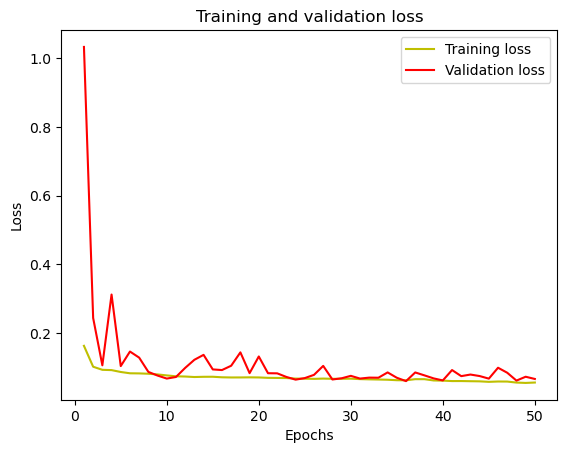

In [40]:
history = att_res_SegNet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

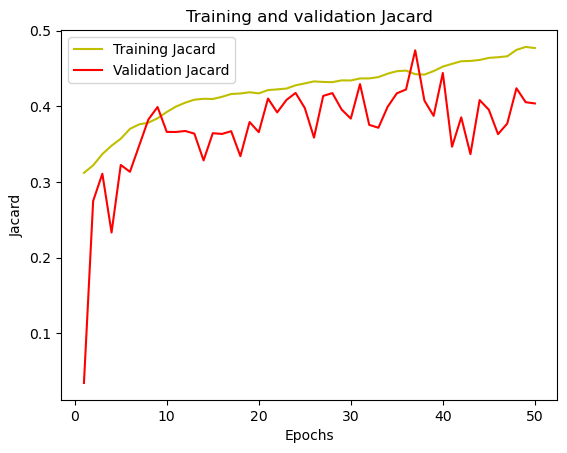

In [41]:
acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

1/1 [==============================] - 0s 76ms/step


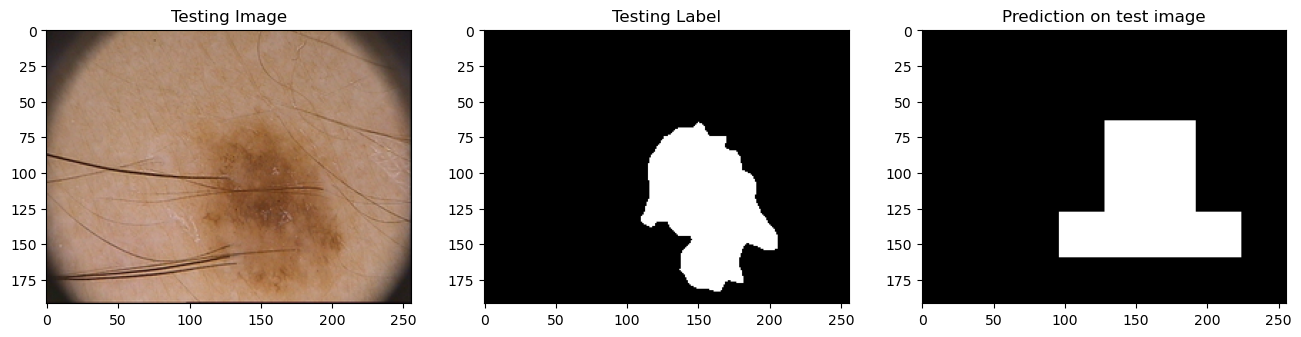

In [44]:
model = att_res_SegNet_model

import random
test_img_number = random.randint(0, x_test.shape[0]-1)
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [45]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("IoU for the above prediction =", IOU_keras.result().numpy())

IoU for the above prediction = 0.7224606


### Calculating mean IoU over the entire dataset

In [37]:
sum_iou=0
for test_img_number in range(x_train_full.shape[0]):
    test_img = x_train_full[test_img_number]
    ground_truth=y_train_full_exp[test_img_number]

    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IOU_keras = MeanIoU(num_classes=n_classes)  
    IOU_keras.update_state(ground_truth[:,:,0], prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
print("Mean IoU: ",sum_iou/x_train_full.shape[0])

1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.9277767
1/1 [==============================] - 0s 54ms/step
IoU for the current prediction = 0.9770956
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.955353
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.97066414
1/1 [==============================] - 0s 72ms/step
IoU for the current prediction = 0.9093318
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.97719973
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.91069996
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.9807918
1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.75527346
1/1 [==============================] - 0s 56ms/step
IoU for the current prediction = 0.9396243
1/1 [==============================] - 0s 60ms/

1/1 [==============================] - 0s 66ms/step
IoU for the current prediction = 0.9765316
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.96575564
1/1 [==============================] - 0s 33ms/step
IoU for the current prediction = 0.9727534
1/1 [==============================] - 0s 62ms/step
IoU for the current prediction = 0.9550717
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.88797116
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.593601
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.8953129
1/1 [==============================] - 0s 60ms/step
IoU for the current prediction = 0.9631138
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.8880472
1/1 [==============================] - 0s 62ms/step
IoU for the current prediction = 0.8520982
1/1 [==============================] - 0s 56ms/st

1/1 [==============================] - 0s 66ms/step
IoU for the current prediction = 0.8428172
1/1 [==============================] - 0s 50ms/step
IoU for the current prediction = 0.970152
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.9821811
1/1 [==============================] - 0s 47ms/step
IoU for the current prediction = 0.8385395
1/1 [==============================] - 0s 69ms/step
IoU for the current prediction = 0.9623227
1/1 [==============================] - 0s 54ms/step
IoU for the current prediction = 0.9681753
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.97308254
1/1 [==============================] - 0s 72ms/step
IoU for the current prediction = 0.9786842
1/1 [==============================] - 0s 80ms/step
IoU for the current prediction = 0.9606094
1/1 [==============================] - 0s 59ms/step
IoU for the current prediction = 0.9363754
1/1 [==============================] - 0s 56ms/ste

1/1 [==============================] - 0s 61ms/step
IoU for the current prediction = 0.939962
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.5119181
1/1 [==============================] - 0s 56ms/step
IoU for the current prediction = 0.95722866
1/1 [==============================] - 0s 40ms/step
IoU for the current prediction = 0.9644573
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.86338514
1/1 [==============================] - 0s 48ms/step
IoU for the current prediction = 0.9385088
1/1 [==============================] - 0s 46ms/step
IoU for the current prediction = 0.82720745
1/1 [==============================] - 0s 58ms/step
IoU for the current prediction = 0.90074563
1/1 [==============================] - 0s 39ms/step
IoU for the current prediction = 0.96266377
1/1 [==============================] - 0s 45ms/step
IoU for the current prediction = 0.9560586
1/1 [==============================] - 0s 50ms

1/1 [==============================] - 0s 73ms/step
IoU for the current prediction = 0.9744006
1/1 [==============================] - 0s 64ms/step
IoU for the current prediction = 0.9568284
1/1 [==============================] - 0s 54ms/step
IoU for the current prediction = 0.90314794
1/1 [==============================] - 0s 65ms/step
IoU for the current prediction = 0.9611671
1/1 [==============================] - 0s 43ms/step
IoU for the current prediction = 0.9116224
1/1 [==============================] - 0s 41ms/step
IoU for the current prediction = 0.95528513
1/1 [==============================] - 0s 40ms/step
IoU for the current prediction = 0.96218663
1/1 [==============================] - 0s 51ms/step
IoU for the current prediction = 0.97071004
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.9753386
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.7976336
1/1 [==============================] - 0s 49ms

1/1 [==============================] - 0s 49ms/step
IoU for the current prediction = 0.96144235
1/1 [==============================] - 0s 63ms/step
IoU for the current prediction = 0.91272616
1/1 [==============================] - 0s 57ms/step
IoU for the current prediction = 0.91220844
1/1 [==============================] - 0s 64ms/step
IoU for the current prediction = 0.9664941
1/1 [==============================] - 0s 65ms/step
IoU for the current prediction = 0.9628563
1/1 [==============================] - 0s 52ms/step
IoU for the current prediction = 0.8823653
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.96507835
1/1 [==============================] - 0s 68ms/step
IoU for the current prediction = 0.95718676
1/1 [==============================] - 0s 53ms/step
IoU for the current prediction = 0.9132275
1/1 [==============================] - 0s 55ms/step
IoU for the current prediction = 0.95059335
1/1 [==============================] - 0s 74

### Interpretability

In [38]:
def visualize_conv_layer(int_out, row_size, col_size):
   
  img_index=0

  print(np.shape(int_out))
  
  fig,ax=plt.subplots(row_size,col_size, figsize=(20, 5))
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(int_out[0, :, :, img_index], cmap='jet')
      ax[row][col].axis('off')
      img_index=img_index+1
        
print("Function to Visualize the Output has been Created")

Function to Visualize the Output has been Created


### If you are loading the model

In [39]:
# att_512_2 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="batch_normalization_22").output,
# )
# att_512_1 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="batch_normalization_28").output,
# )
# att_256 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="batch_normalization_34").output,
# )
# att_128 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="batch_normalization_40").output,
# )
# att_64 = tf.keras.models.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="batch_normalization_45").output,
# )

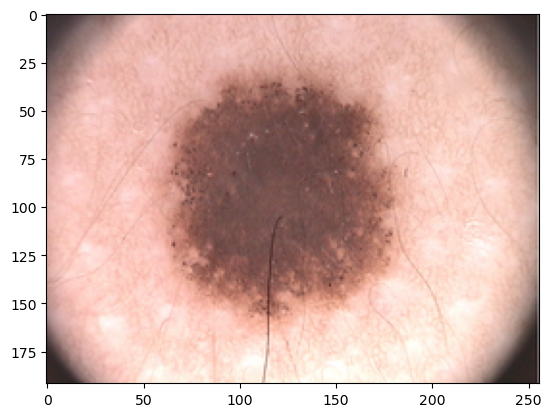

In [40]:
# selecting the image for interpretability
test_img_input = np.expand_dims(x_test[2], 0)
plt.imshow(x_test[2])

Attention block 1
1/1 [==============================] - 1s 542ms/step
(1, 12, 16, 512)


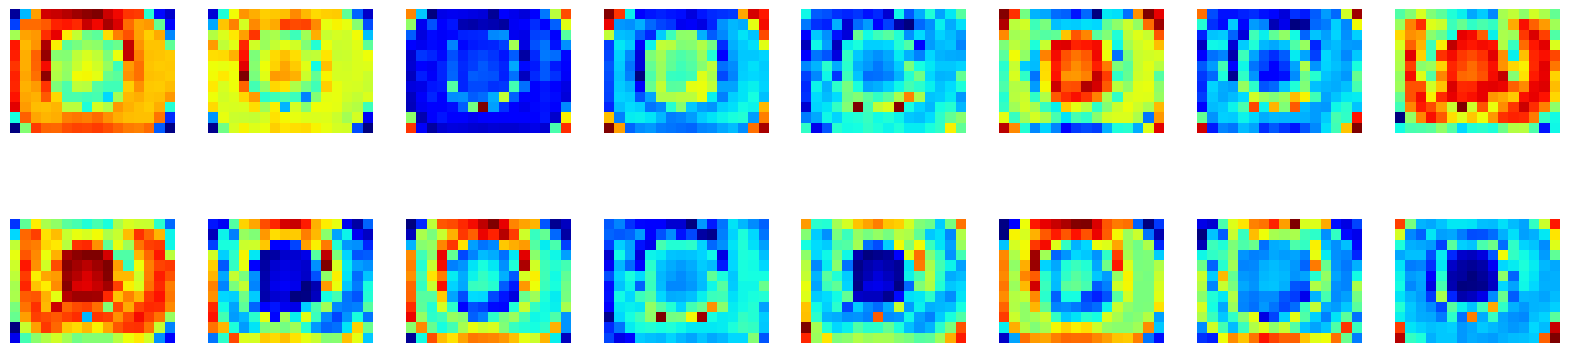

In [41]:
attention_blocks = [att_512_2, att_512_1, att_256, att_128, att_64]
print("Attention block 1")
in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[0])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 2
1/1 [==============================] - 1s 1s/step
(1, 24, 32, 512)


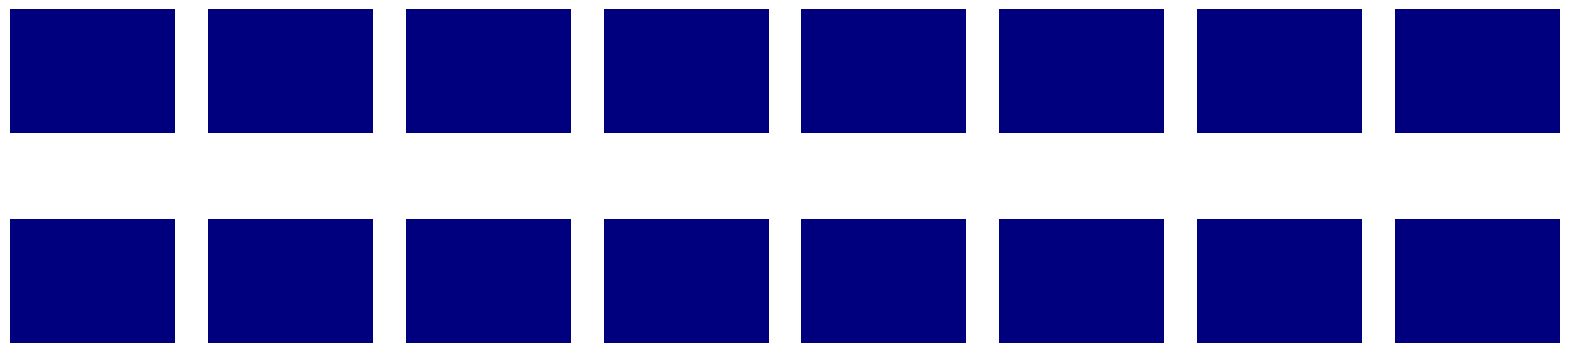

In [42]:
print("Attention block 2")
in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[1])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2 ,8)

Attention block 3
1/1 [==============================] - 1s 945ms/step
(1, 48, 64, 256)


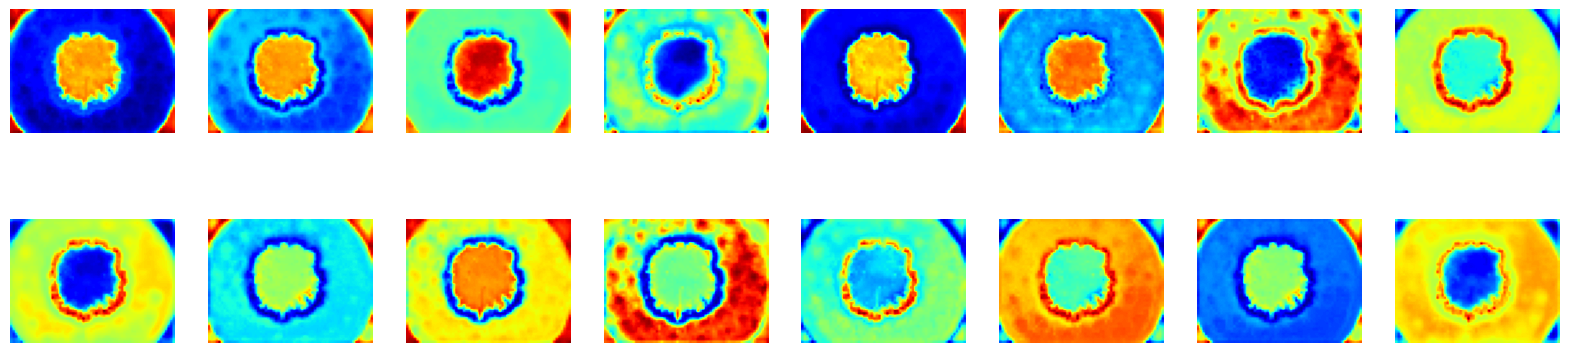

In [43]:
print("Attention block 3")
in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[2])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 4
1/1 [==============================] - 1s 1s/step
(1, 96, 128, 128)


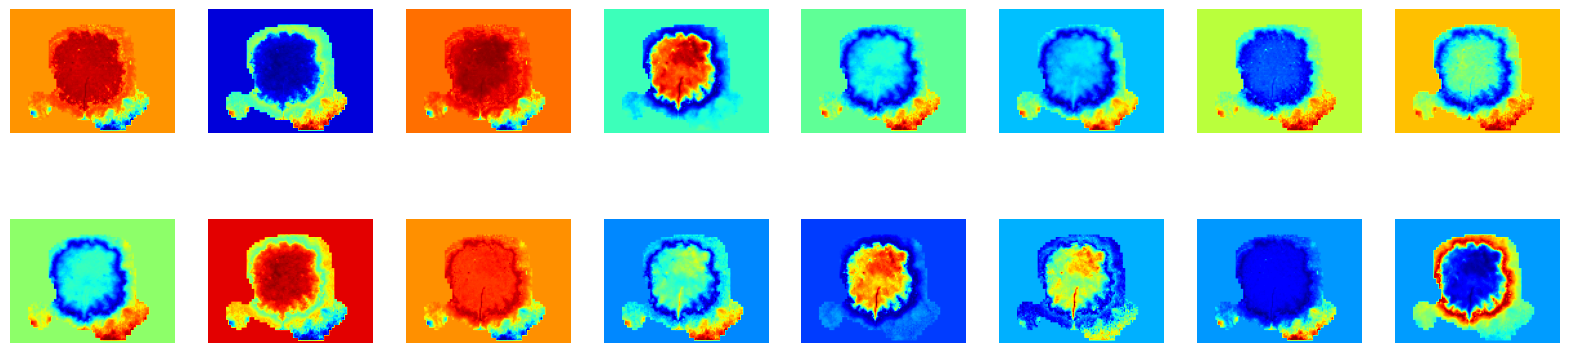

In [44]:
print("Attention block 4")
in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[3])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 5
1/1 [==============================] - 1s 1s/step
(1, 192, 256, 64)


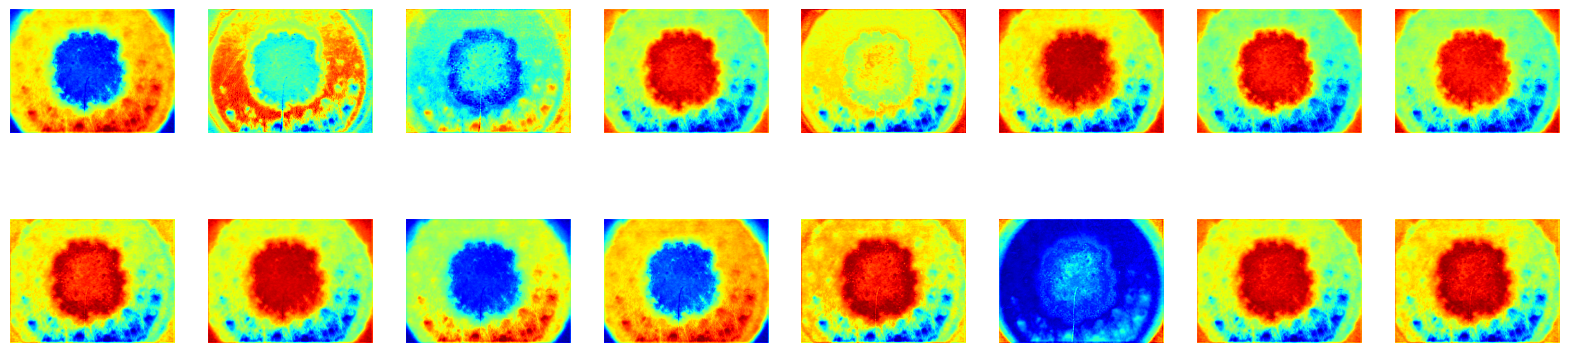

In [45]:
print("Attention block 5")
in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[4])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

### Max Intensity Projection (MPI)

In [46]:
import SimpleITK as sitk

#### Constructing the numpy image stack

In [47]:
import numpy as np
import nibabel as nib

In [48]:
for i in range(5):
    in_to_intermediate = Model(inputs=model.inputs, outputs=attention_blocks[i])
    int_out = in_to_intermediate.predict(test_img_input)

    path_to_save = 'attention_nii_files/atten_'+str(i)+'.nii'

    converted_array = np.array(int_out[0], dtype=np.float32) # You need to replace normal array by yours
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)

    nib.save(nifti_file, path_to_save)

1/1 [==============================] - 1s 1s/step


In [61]:
def make_mips(image_path, output_dir):
    image = sitk.ReadImage(image_path)
    image_size = image.GetSize()

    basename = os.path.basename(image_path)
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    for dim in range(3):
        projection = sitk.MaximumProjection(image, dim)

        if image_size[dim] % 2:  # odd number
            voxel = [0, 0, 0]
            voxel[dim] = (image_size[dim] - 1) / 2
            origin = image.TransformIndexToPhysicalPoint(voxel)
        else:  # even
            voxel1 = np.array([0, 0, 0], int)
            voxel2 = np.array([0, 0, 0], int)
            voxel1[dim] = image_size[dim] / 2 - 1
            voxel2[dim] = image_size[dim] / 2
            point1 = np.array(image.TransformIndexToPhysicalPoint(voxel1.tolist()))
            point2 = np.array(image.TransformIndexToPhysicalPoint(voxel2.tolist()))
            origin = np.mean(np.vstack((point1, point2)), 0)
        projection.SetOrigin(origin)
        projection.SetDirection(image.GetDirection())
        proj_basename = basename.replace('.nii.gz', '_mip_{}.nii.gz'.format(dim))
        sitk.WriteImage(projection, os.path.join(output_dir, proj_basename))


In [62]:
for i in range(5):

    image_path = 'attention_nii_files/atten_'+str(i)+'.nii'
    output_dir = 'attention_nii_files/attention_mip/'
    make_mips(image_path, output_dir)

In [63]:
for i in range(5):
    out_np_path = 'attention_nii_files/attention_mip/atten_'+str(i)+'.nii'
    out_img = nib.load(out_np_path)
    out_img = np.array(out_img.dataobj, dtype='int16')
    out_img = np.squeeze(out_img)
    cv2.imwrite('img_'+str(i)+'.png', out_img)
#     plt.imsave('img_'+str(i)+'.png', out_img)

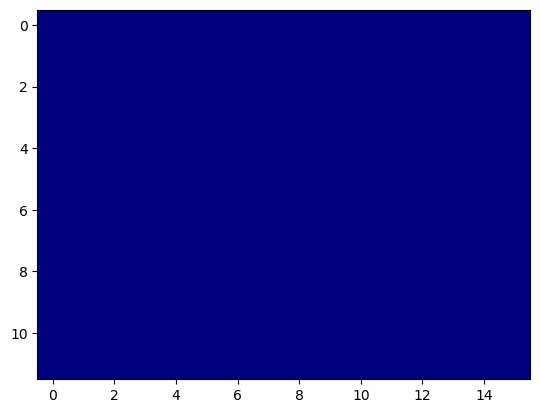

In [64]:
fname = 'attention_nii_files/Atten_maps/img_0.png'
plt.imshow(Image.open(fname), cmap = 'jet')

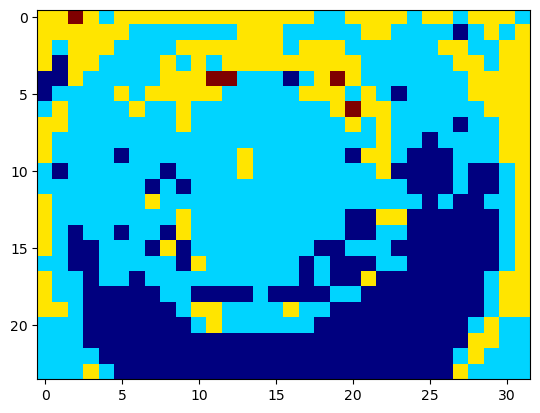

In [65]:
fname = 'attention_nii_files/Atten_maps/img_1.png'
plt.imshow(Image.open(fname), cmap = 'jet')

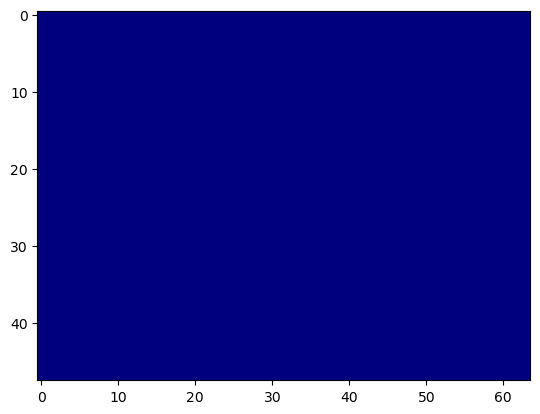

In [66]:
fname = 'attention_nii_files/Atten_maps/img_2.png'
plt.imshow(Image.open(fname), cmap = 'jet')

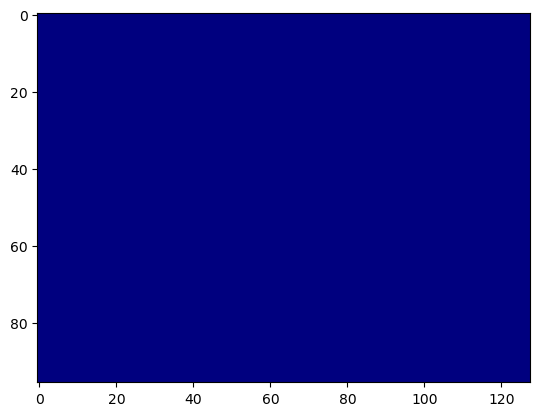

In [67]:
fname = 'attention_nii_files/Atten_maps/img_3.png'
plt.imshow(Image.open(fname), cmap = 'jet')

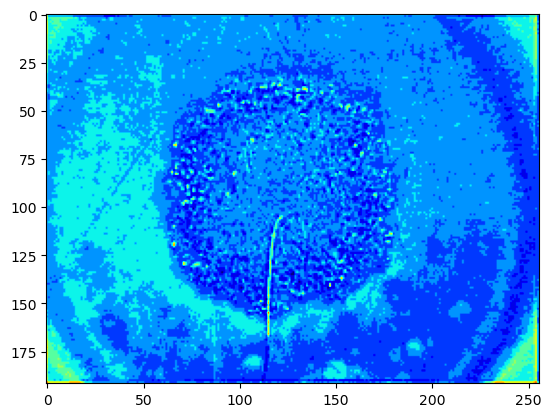

In [68]:
fname = 'attention_nii_files/Atten_maps/img_4.png'
plt.imshow(Image.open(fname), cmap = 'jet')

### Visualizing convolutional blocks 

In [57]:
conv_enc_blocks = [conv_64, conv_128, conv_256, conv_512_1, conv_512_2]

In [58]:
conv_dec_blocks = [up_conv_512_2, up_conv_512_1, up_conv_256, up_conv_128, up_conv_64]

In [59]:
for i in range(5):
    in_to_intermediate = Model(inputs=model.inputs, outputs=conv_enc_blocks[i])
    int_out = in_to_intermediate.predict(test_img_input)

    path_to_save = 'attention_nii_files/conv_enc_mip/conv_enc_'+str(i)+'.nii'

    converted_array = np.array(int_out[0], dtype=np.float32) # You need to replace normal array by yours
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)

    nib.save(nifti_file, path_to_save)

1/1 [==============================] - 0s 363ms/step


In [70]:
for i in range(5):

    image_path = 'attention_nii_files/conv_enc_mip/conv_enc_'+str(i)+'.nii'
    output_dir = 'attention_nii_files/conv_enc_mpi/'
    make_mips(image_path, output_dir)

In [71]:
for i in range(5):
    out_np_path = 'attention_nii_files/conv_enc_mpi/conv_enc_'+str(i)+'.nii'
    out_img = nib.load(out_np_path)
    out_img = np.array(out_img.dataobj, dtype='int16')
    out_img = np.squeeze(out_img)
    cv2.imwrite('attention_nii_files/conv_enc_mpi/img_'+str(i)+'.png', out_img)

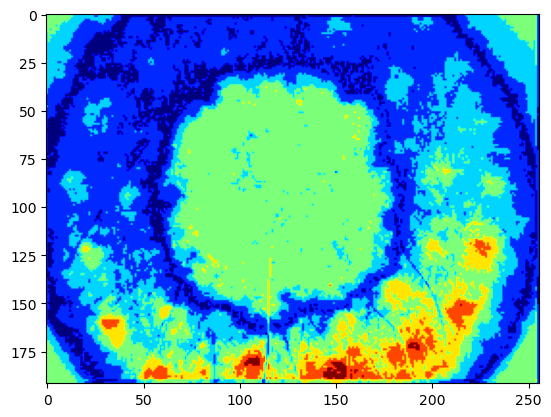

In [72]:
fname = 'attention_nii_files/conv_enc_mpi/img_0.png'
plt.imshow(Image.open(fname), cmap = 'jet')

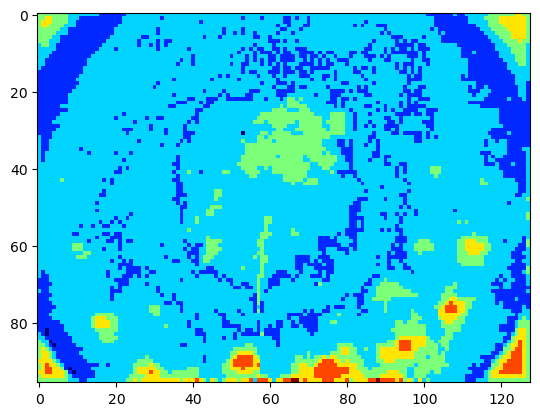

In [73]:
fname = 'attention_nii_files/conv_enc_mpi/img_1.png'
plt.imshow(Image.open(fname), cmap = 'jet')

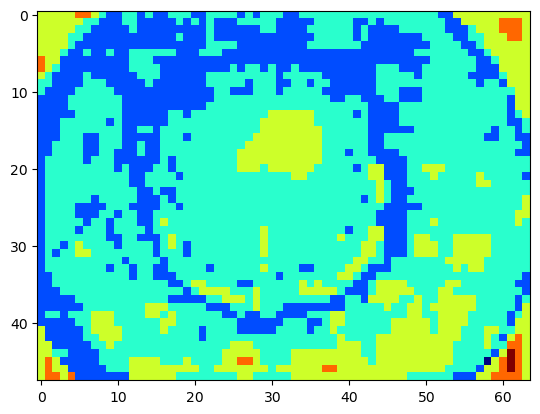

In [74]:
fname = 'attention_nii_files/conv_enc_mpi/img_2.png'
plt.imshow(Image.open(fname), cmap = 'jet')

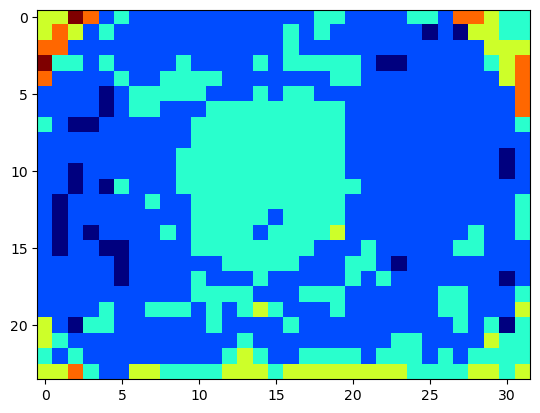

In [75]:
fname = 'attention_nii_files/conv_enc_mpi/img_3.png'
plt.imshow(Image.open(fname), cmap = 'jet')

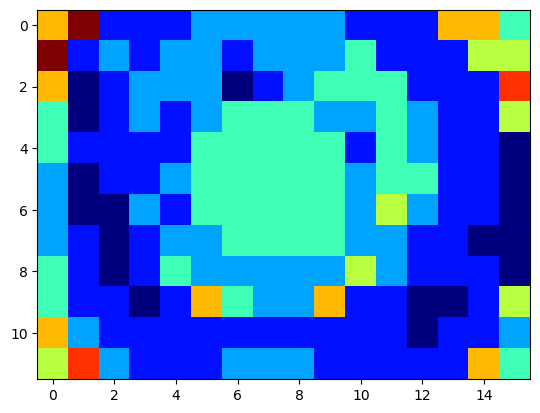

In [76]:
fname = 'attention_nii_files/conv_enc_mpi/img_4.png'
plt.imshow(Image.open(fname), cmap = 'jet')

### Visualizing deconvolution blocks

In [77]:
for i in range(5):
    in_to_intermediate = Model(inputs=model.inputs, outputs=conv_dec_blocks[i])
    int_out = in_to_intermediate.predict(test_img_input)

    path_to_save = 'attention_nii_files/conv_dec_mip/conv_dec_'+str(i)+'.nii'

    converted_array = np.array(int_out[0], dtype=np.float32) # You need to replace normal array by yours
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)

    nib.save(nifti_file, path_to_save)

1/1 [==============================] - 1s 1s/step


In [78]:
for i in range(5):

    image_path = 'attention_nii_files/conv_dec_mip/conv_dec_'+str(i)+'.nii'
    output_dir = 'attention_nii_files/conv_dec_mpi/'
    make_mips(image_path, output_dir)

In [79]:
for i in range(5):
    out_np_path = 'attention_nii_files/conv_dec_mpi/conv_dec_'+str(i)+'.nii'
    out_img = nib.load(out_np_path)
    out_img = np.array(out_img.dataobj, dtype='int16')
    out_img = np.squeeze(out_img)
    cv2.imwrite('attention_nii_files/conv_dec_mpi/img_'+str(i)+'.png', out_img)

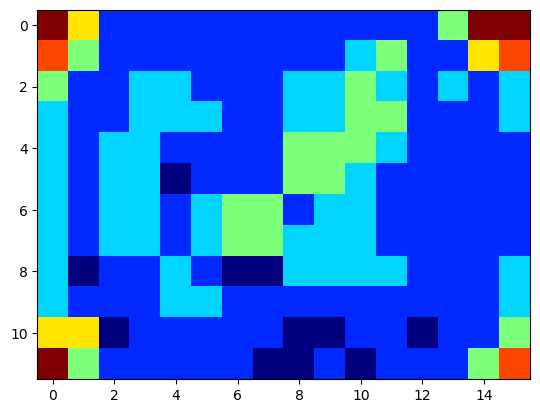

In [80]:
fname = 'attention_nii_files/conv_dec_mpi/img_0.png'
plt.imshow(Image.open(fname), cmap = 'jet')

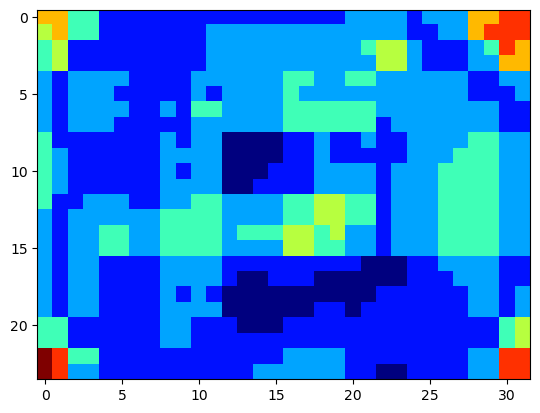

In [81]:
fname = 'attention_nii_files/conv_dec_mpi/img_1.png'
plt.imshow(Image.open(fname), cmap = 'jet')

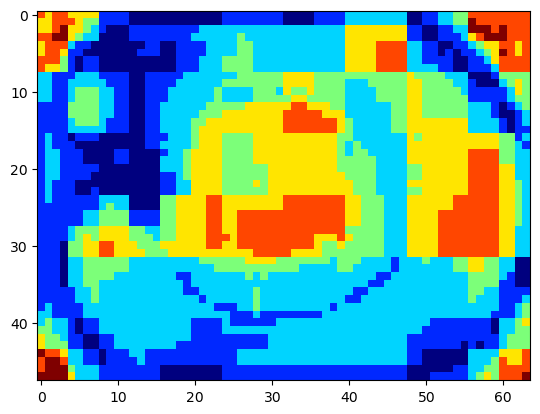

In [82]:
fname = 'attention_nii_files/conv_dec_mpi/img_2.png'
plt.imshow(Image.open(fname), cmap = 'jet')

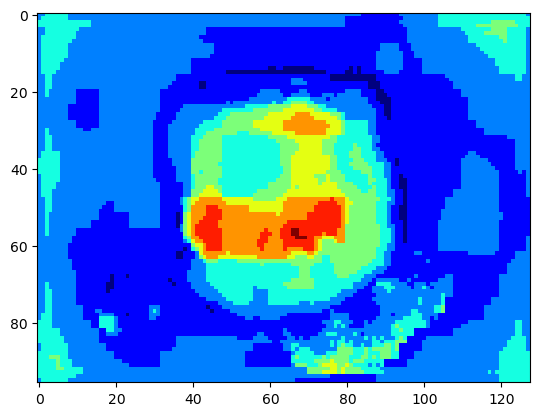

In [83]:
fname = 'attention_nii_files/conv_dec_mpi/img_3.png'
plt.imshow(Image.open(fname), cmap = 'jet')

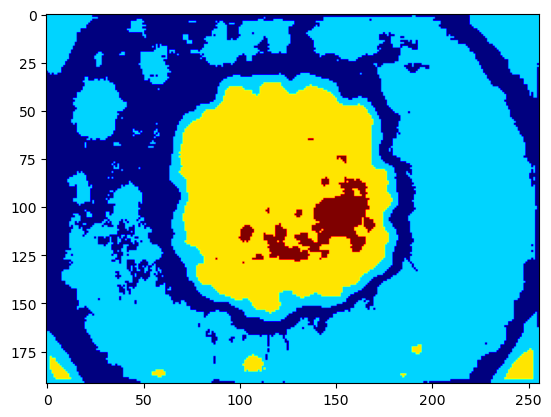

In [85]:
fname = 'attention_nii_files/conv_dec_mpi/img_4.png'
plt.imshow(Image.open(fname), cmap = 'jet')